In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, initializers, applications
import numpy as np
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
BASE_DIR = os.getcwd()
print(BASE_DIR)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)


/mnt/cd1/home/teacher/notebooks/cv_project_2days/image_segmentation/FCN-seg


## 1.模型搭建

<img src="./data/model.png"  width="600" height="700" align="bottom" />

In [2]:
num_classes = 21        # 要素之一：分类类别
input_shape=(320, 480, 3) 
path_pretrained_model = os.path.join(BASE_DIR, "data", "resnet101v2_weights_tf_dim_ordering_tf_kernels_notop.h5")
# include_top=False ， 不包含FC层， 仅需要backbone中
pretrained_net = applications.ResNet101V2(include_top=False, weights=path_pretrained_model, input_shape=input_shape)

net = keras.Sequential()
 # part1：预训练模型输出为 backbone提取的特征图， resnet最终特征图下降32倍分辨率
net.add(pretrained_net) 
 # part2:利用卷积层确定输出数据通道数，用于分类类别确定
net.add(keras.layers.Conv2D(num_classes, kernel_size=1, activation='relu')) 
 # part3：利用转置卷积上采样 32倍 
net.add(keras.layers.Conv2DTranspose(num_classes, kernel_size=64, padding='same',strides=32))
 # part4：输出通过softmax获取分类概率向量
net.add(keras.layers.Softmax(axis=-1))   

In [3]:
# 参数初始化
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1-abs(og[0]-center)/factor) * (1-abs(og[1]-center)/factor)

    # kernel_size = (kernel_size, kernel_size, in_channels, out_channels)
    weight = np.zeros((kernel_size, kernel_size, in_channels, out_channels), dtype='float32')
    weight[:, :, range(in_channels), range(out_channels)] = filt.reshape((kernel_size,kernel_size,1))
    return weight

for i in range(-2, -1):
    bias_weight = net.layers[i].get_weights()[1]
    kernel_size = net.layers[i].get_config()['kernel_size'][0]
    net.layers[i].set_weights([bilinear_kernel(num_classes, num_classes, kernel_size),
                bias_weight])

## 2. 数据集定义

#### 核心在于voc_label_indices，如何将硬盘中标签数据转为模型训练使用的标签形式
#### 这里将RGB --> index 

In [4]:

def show_images(imgs, num_rows, num_cols, scale=2):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i * num_cols + j])
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    return axes


def voc_label_indices(colormap, colormap2label):
    """
    convert colormap (tf image) to colormap2label (uint8 tensor).
    """
    colormap = tf.cast(colormap, dtype=tf.int32)
    idx = tf.add(tf.multiply(colormap[:, :, 0], 256), colormap[:, :, 1])
    idx = tf.add(tf.multiply(idx, 256), colormap[:, :, 2])

    return tf.gather_nd(colormap2label, tf.expand_dims(idx, -1))


def voc_rand_crop(feature, label, height, width):
    """
    Random crop feature (tf image) and label (tf image).
    先将channel合并，剪裁之后再分开
    """
    combined = tf.concat([feature, label], axis=2)
    last_label_dim = tf.shape(label)[-1]
    last_feature_dim = tf.shape(feature)[-1]
    combined_crop = tf.image.random_crop(combined,
                                         size=tf.concat([(height, width), [last_label_dim + last_feature_dim]], axis=0))
    return combined_crop[:, :, :last_feature_dim], combined_crop[:, :, last_feature_dim:]


def read_voc_images(root=None, is_train=True, max_num=None):
    txt_fname = '%s/ImageSets/Segmentation/%s' % (root, 'train.txt' if is_train else 'val.txt')
    
    # 读取txt文件，获得每张图片的文件名
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    
    if max_num is not None:
        images = images[:min(max_num, len(images))]
    features, labels = [None] * len(images), [None] * len(images)
    
    # 读取图片存在features和labels中
    for i, fname in tqdm(enumerate(images)):
        feature_tmp = tf.io.read_file('%s/JPEGImages/%s.jpg' % (root, fname))
        features[i] = tf.image.decode_jpeg(feature_tmp)
        label_tmp = tf.io.read_file('%s/SegmentationClass/%s.png' % (root, fname))
        labels[i] = tf.image.decode_png(label_tmp)
    return features, labels  # shape=(h, w, c)


def getVOCSegDataset(is_train, crop_size, voc_dir, colormap2label, max_num=None):
    """
    crop_size: (h, w)
    """
    features, labels = read_voc_images(root=voc_dir,
                                       is_train=is_train,
                                       max_num=max_num)

    def _filter(imgs, crop_size):
        return [img for img in imgs if (
                img.shape[0] >= crop_size[0] and
                img.shape[1] >= crop_size[1])]

    def _crop(features, labels):
        features_crop = []
        labels_crop = []
        for feature, label in zip(features, labels):
            feature, label = voc_rand_crop(feature, label,
                                           height=crop_size[0],
                                           width=crop_size[1])
            features_crop.append(feature)
            labels_crop.append(label)
        return features_crop, labels_crop

    def _normalize(feature, label):
        rgb_mean = np.array([0.485, 0.456, 0.406])
        rgb_std = np.array([0.229, 0.224, 0.225])

        label = voc_label_indices(label, colormap2label)
        feature = tf.cast(feature, tf.float32)
        feature = tf.divide(feature, 255.)
        # 我试着去掉这个反而更准
        # feature = tf.divide(tf.subtract(feature, rgb_mean), rgb_std)
        return feature, label

    features = _filter(features, crop_size)
    labels = _filter(labels, crop_size)
    features, labels = _crop(features, labels)

    print('read ' + str(len(features)) + ' valid examples')
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    dataset = dataset.map(_normalize)
    return dataset
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

In [5]:
voc_dir = os.path.join(BASE_DIR, "..", "..", "object_detection", "data", "VOCdevkit", "VOC2012")  # linux
# voc_dir = r"G:\deep_learning_data\VOCdevkit\VOC2012"
batch_size = 8 # 24 in linux
max_epoch = 20
lr_init = 0.001

crop_size = (320, 480)
colormap2label = np.zeros(256 ** 3, dtype=np.uint8)
for i, colormap in enumerate(VOC_COLORMAP):
    colormap2label[(colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i

colormap2label = tf.convert_to_tensor(colormap2label)

In [6]:
voc_train = getVOCSegDataset(True, crop_size, voc_dir, colormap2label)
voc_test = getVOCSegDataset(False, crop_size, voc_dir, colormap2label)

voc_train = voc_train.shuffle(buffer_size=64).batch(batch_size)
voc_test = voc_test.shuffle(buffer_size=64).batch(1)

1464it [00:21, 66.80it/s]


read 1114 valid examples


1449it [00:28, 50.43it/s]


read 1078 valid examples


## 3.模型训练

In [ ]:
net.compile(optimizer=tf.keras.optimizers.Adam(lr=lr_init),
        loss=keras.losses.sparse_categorical_crossentropy,
        metrics=['accuracy'])
net.fit(voc_train, epochs=max_epoch, validation_data=voc_test)

Epoch 1/20
  8/140 [>.............................] - ETA: 1:07 - loss: 2.2147 - accuracy: 0.4844

In [ ]:
path_model_fcn = os.path.join(BASE_DIR, "data", "fcn_voc_pretrained_model.h5")
net.save_weights(path_model_fcn)

## 4. 模型预测

In [20]:
path_model_fcn = os.path.join(BASE_DIR, "data", "fcn_081acc_50epoch.h5")
net.load_weights(path_model_fcn)

In [21]:
def predict(img):
    rgb_mean = np.array([0.485, 0.456, 0.406])
    rgb_std = np.array([0.229, 0.224, 0.225])
    feature = tf.cast(img, tf.float32)
    feature = tf.divide(feature, 255.)
    # feature = tf.divide(tf.subtract(feature, rgb_mean), rgb_std)
    x = tf.expand_dims(feature, axis=0)
    return net.predict(x)

def label2image(pred):
    colormap = np.array(VOC_COLORMAP, dtype='float32')
    x = colormap[tf.argmax(pred, axis=-1)]
    return x

10it [00:00, 86.43it/s]
<ipython-input-21-9238e8cfaeea>:12: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  x = colormap[tf.argmax(pred, axis=-1)]


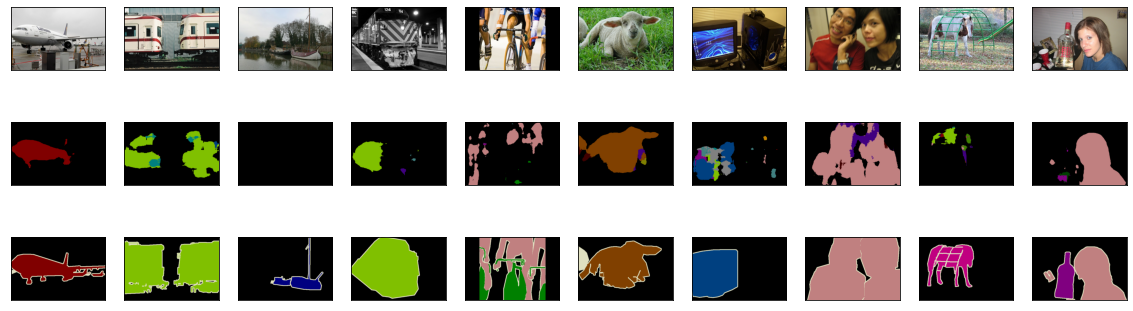

In [22]:
n = 10
imgs = []
test_images, test_labels = read_voc_images(root=voc_dir, is_train=False, max_num=n)

for i in range(n):
    x = tf.image.resize_with_crop_or_pad(test_images[i], 320, 480)  # 获取单张图片
    pred = predict(x)                                               # 输入模型预测，拿到的是逐像素的index
    pred = label2image(pred)                                        # index转换为 RGB，用于可视化
    pred = tf.cast(pred, tf.uint8)  
    imgs += [x, pred, tf.image.resize_with_crop_or_pad(test_labels[i], 320, 480)]

ax = show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n)
plt.show()